In [1]:
import pyexasol
import pandas as pd
import boto3
import time
import io
import numpy as np
from matplotlib import pyplot as plt

class QueryAthena:

    def __init__(self, query, database):
        self.database = 'btb-serving'
        self.folder = 'api/'
        self.bucket = 'btb-athena-query-results'
        self.s3_input = 's3://' + self.bucket + '/my_folder_input'
        self.s3_output =  's3://' + self.bucket + '/' + self.folder
        self.region_name = 'eu-central-1'
        self.query = query
        self.access_key = '***'
        self.secret_key = '***'

    def load_conf(self, q):
        
        try:
            self.client = boto3.client('athena', region_name = self.region_name, aws_access_key_id=self.access_key,
                                  aws_secret_access_key=self.secret_key)
            
            response = self.client.start_query_execution(
                QueryString = q,
                    QueryExecutionContext={
                    'Database': self.database
                    },
                    ResultConfiguration={
                    'OutputLocation': self.s3_output,
                    }
            )
            self.filename = response['QueryExecutionId']
            print('Execution ID: ' + response['QueryExecutionId'])

        except Exception as e:
            print(e)
        return response                

    def run_query(self):
        queries = [self.query]
        for q in queries:
            res = self.load_conf(q)
        try:              
            query_status = None
            while query_status == 'QUEUED' or query_status == 'RUNNING' or query_status is None:
                query_status = self.client.get_query_execution(QueryExecutionId=res["QueryExecutionId"])['QueryExecution']['Status']['State']
                query_status2 = self.client.get_query_execution(QueryExecutionId=res["QueryExecutionId"])['QueryExecution']['Status']
                print(query_status2)
                if query_status == 'FAILED' or query_status == 'CANCELLED':
                    raise Exception('Athena query with the string "{}" failed or was cancelled'.format(self.query))
                time.sleep(0.2)
            print('Query "{}" finished.'.format(self.query))

            df = self.obtain_data()
            return df

        except Exception as e:
            print(e)      

    def obtain_data(self):
        try:
            self.resource = boto3.resource('s3', 
                                  region_name = self.region_name,
                                  aws_access_key_id=self.access_key,
                                  aws_secret_access_key=self.secret_key)
                                  
            print(self.bucket)
            print(self.folder)
            print(self.filename)
            
            # S3 Object
            res_obj = self.resource.Object(bucket_name=self.bucket, key=self.folder + self.filename + '.csv')
            response = res_obj.get()
            
            return pd.read_csv(io.BytesIO(response['Body'].read()), encoding='utf8')   
        except Exception as e:
            print(e) 

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

In [3]:
v_sql_home = """
select
    round(home_xg_for_ema,1)               home_xg_for_ema,
    round(away_xg_against_ema,1)           away_xg_against_ema,
    full_time_home_goals
from
    "ml_poisson_features"
where
    feature_type = 'EMA10 COMB' and
    home_goals_for_ema is not null and
    home_goals_against_ema is not null and
    away_goals_for_ema is not null and
    away_goals_against_ema is not null and
    home_xg_for_ema is not null and
    home_xg_against_ema is not null and
    away_xg_for_ema is not null and
    away_xg_against_ema is not null and
    home_shots_for_ema is not null and
    home_shots_against_ema is not null and
    away_shots_for_ema is not null and
    away_shots_against_ema is not null and
    home_sot_for_ema is not null and
    home_sot_against_ema is not null and
    away_sot_for_ema is not null and
    away_sot_against_ema is not null and
    home_corners_for_ema is not null and
    home_corners_against_ema is not null and
    away_corners_for_ema is not null and
    away_corners_against_ema is not null and
    home_deep_for_ema is not null and
    home_deep_against_ema is not null and
    away_deep_for_ema is not null and
    away_deep_against_ema is not null and
    home_ppda_for_ema is not null and
    home_ppda_against_ema is not null and
    away_ppda_for_ema is not null and
    away_ppda_against_ema is not null and
    full_time_home_goals is not null and
    full_time_away_goals is not null
    """

v_sql_away = """
select
    round(home_xg_against_ema,1)           home_xg_against_ema,
    round(away_xg_for_ema,1)               away_xg_for_ema,
    full_time_away_goals               full_time_away_goals
from
    "ml_poisson_features"
where
    feature_type = 'EMA10 COMB' and
    home_goals_for_ema is not null and
    home_goals_against_ema is not null and
    away_goals_for_ema is not null and
    away_goals_against_ema is not null and
    home_xg_for_ema is not null and
    home_xg_against_ema is not null and
    away_xg_for_ema is not null and
    away_xg_against_ema is not null and
    home_shots_for_ema is not null and
    home_shots_against_ema is not null and
    away_shots_for_ema is not null and
    away_shots_against_ema is not null and
    home_sot_for_ema is not null and
    home_sot_against_ema is not null and
    away_sot_for_ema is not null and
    away_sot_against_ema is not null and
    home_corners_for_ema is not null and
    home_corners_against_ema is not null and
    away_corners_for_ema is not null and
    away_corners_against_ema is not null and
    home_deep_for_ema is not null and
    home_deep_against_ema is not null and
    away_deep_for_ema is not null and
    away_deep_against_ema is not null and
    home_ppda_for_ema is not null and
    home_ppda_against_ema is not null and
    away_ppda_for_ema is not null and
    away_ppda_against_ema is not null and
    full_time_home_goals is not null and
    full_time_away_goals is not null
    """

    
qa = QueryAthena(query=v_sql_home, database='btb-serving')
df_data_home = qa.run_query()

qa = QueryAthena(query=v_sql_away, database='btb-serving')
df_data_away = qa.run_query()

Execution ID: 973115b8-bae4-427a-ab27-68f9426271b6
{'State': 'QUEUED', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 13, 184000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 13, 184000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 13, 184000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 13, 184000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 13, 184000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 13, 184000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 13, 184000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 13, 184000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': dat

Execution ID: 03642ffb-4b9a-44f8-b50c-cd5b79666de1
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 32, 589000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 32, 589000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 32, 589000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 32, 589000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 32, 589000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 32, 589000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 32, 589000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': datetime.datetime(2022, 7, 25, 11, 15, 32, 589000, tzinfo=tzlocal())}
{'State': 'RUNNING', 'SubmissionDateTime': da

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Best: -1.245862 using {'max_depth': 4, 'max_features': 2, 'n_estimators': 120}
Best: -1.245862 using {'max_depth': 4, 'max_features': 2, 'n_estimators': 120}
-1.268266 (0.010663) with: {'max_depth': 2, 'max_features': 2, 'n_estimators': 60}
-1.267992 (0.010655) with: {'max_depth': 2, 'max_features': 2, 'n_estimators': 80}
-1.268088 (0.010186) with: {'max_depth': 2, 'max_features': 2, 'n_estimators': 100}
-1.268226 (0.010631) with: {'max_depth': 2, 'max_features': 2, 'n_estimators': 120}
-1.246261 (0.012305) with: {'max_depth': 4, 'max_features': 2, 'n_estimators': 60}
-1.246038 (0.012082) with: {'max_depth': 4, 'max_features': 2, 'n_estimators': 80}
-1.245965 (0.012452) with: {'max_depth': 4, 'max_features': 2, 'n_estimators': 100}
-1.245862 (0.012035) with: {'max_depth': 4, 'max_features': 2, 'n_estimators': 120}
-1.248056 (0.013167) with: {'max_depth': 6, 'max_features': 2, 'n_estimators': 60}
-1.248518 (0.013701) with: {'max_depth': 6, 'max_features': 2, 'n_estimators': 80}
-1.24830

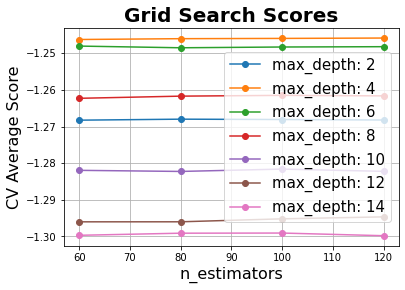

In [7]:

#
#
# Random forest
# Grid Search
#

import pandas
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


#x = df_data_home.iloc[:,:2]
#y = df_data_home.iloc[:,2]

x = df_data_away.iloc[:,:2]
y = df_data_away.iloc[:,2]

#print(x.head(5))
#print(y.head(5))

# define models and parameters
model = RandomForestRegressor()

#home expected goals -> -1.53
#max_depth = [5]
#min_samples_leaf = [10]
#min_samples_split = [150]
#max_leaf_nodes = [20]
#n_estimators = [100]
#max_features = [2]

#away expected goals -> -1,24
max_depth = [4]
#min_samples_leaf = [10]
#min_samples_split = [150]
#max_leaf_nodes = [100]
n_estimators = [100]
max_features = [2]


# define grid search
grid = dict(max_depth=max_depth, 
 #           min_samples_leaf=min_samples_leaf, 
  #          min_samples_split=min_samples_split, 
           # max_leaf_nodes=max_leaf_nodes, 
            n_estimators=n_estimators,
           max_features=max_features)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error',error_score=0)
grid_result = grid_search.fit(x, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

plot_grid_search(grid_result.cv_results_, n_estimators, max_depth, 'n_estimators', 'max_depth')